In [2]:
%run ../modules.ipynb
sys.path.append('../0. kernel-tutorials/')
# Local Utilities for Notebook
from utilities.kernels import linear_kernel, gaussian_kernel
from utilities.general import load_variables, get_stats
from utilities.plotting import (
    plot_base, 
    plot_projection,
    plot_regression,
    plot_simple,
    get_cmaps,
    table_from_dict,
    check_mirrors,
)
cmaps = get_cmaps()
plt.style.use("../0. kernel-tutorials/utilities/kernel_pcovr.mplstyle")
dbl_fig = (2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1])

kernel_params = {"kernel": "rbf", "gamma": 1}
kernel_func = partial(rbf_kernel, gamma=1)
kernel_type = "gaussian"

n_FPS = 7000
n_frames = 10988

In [3]:
"""importing reduced dataset without nan, 7676 entries"""

# from matminer.datasets import load_dataset

# df1 = load_dataset("mp_all_20181018")
# df1.dropna(inplace=True)
# df1.reset_index(drop=True, inplace=True)

# compression_opts = dict(method='zip',
#                         archive_name='MP_red.csv')  

# df1.to_csv('MP_red.zip', index=False,
#           compression=compression_opts)  

# ase_frames=[]
# for i in df1['initial structure']:
#     frame=get_atoms(i)
# #     frame.wrap(eps=1e-12)
#     ase_frames.append(frame)
    
# xyz=ase.io.write('MP_red.xyz', ase_frames)


'importing reduced dataset without nan, 7676 entries'

In [4]:
# zf = zipfile.ZipFile('./MP_red.zip') 
# df_csv_red = pd.read_csv(zf.open('MP_red.csv'), usecols=['e_hull','gap pbe', 'mu_b',
#                                                          'structure', 'elastic anisotropy','bulk modulus', 'shear modulus', 'e_form'])
# frames_init_red=ase.io.read('MP_red.xyz', index=':')
# for frame in frames_init_red:
#     frame.wrap(eps=1e-10)

In [5]:
# len(frames_init_red)

In [6]:
# print(len(df_csv_red))
# natoms_list_tot=[]
# for i in range(len(df_csv_red)):
#     natoms_list_tot.append(natoms(df_csv_red['structure'][i]))
# df_csv_red['natoms']=natoms_list_tot

# magic=[]
# for i in range(len(df_csv_red)):
#     if natoms_list_tot[i]%4==0:
#         m=1
#     else:
#         m=0
#     magic.append(m)
# df_csv_red['magic']=magic   

# df_csv_red.head()

In [7]:
"""Whole dataset with all nan values 83989 entries"""

"""The file has been created in zip format, reading it"""

frames_init_tot=ase.io.read('MP_complete_init.xyz', index=':')
frames_relax_tot=ase.io.read('MP_complete_relax.xyz', index=':')

for frame in frames_relax_tot:
    frame.wrap(eps=1e-10)
for frame in frames_init_tot:
    frame.wrap(eps=1e-10)
   
zf = zipfile.ZipFile('./MP_complete.zip') 
df_csv = pd.read_csv(zf.open('MP_complete.csv'))

natoms_list_tot=[]
magic=[]
for i in range(len(df_csv)):
    natoms_list_tot.append(natoms(df_csv['structure'][i]))
    
df_csv['natoms']=natoms_list_tot
magic=[]
for i in range(len(df_csv)):
    if natoms_list_tot[i]%4==0:
        m=1
    else:
        m=0
    magic.append(m)
df_csv['magic']=magic             
df_csv.head()

,mpid,formula,e_hull,gap pbe,mu_b,elastic anisotropy,bulk modulus,shear modulus,structure,e_form,initial structure,natoms,magic
0,mp-85,In,0.003319,0.0000,2.700000e-05,1.044699,33.154748,4.904836,Full Formula (In1)\nReduced Formula: In\nabc ...,0.003319,Full Formula (In1)\nReduced Formula: In\nabc ...,1,0
1,mp-110,Mg,0.039182,0.0000,-1.360000e-05,-11.326659,35.636106,1.830272,Full Formula (Mg1)\nReduced Formula: Mg\nabc ...,0.039182,Full Formula (Mg1)\nReduced Formula: Mg\nabc ...,1,0
2,mp-20,Be,0.108143,0.0000,1.000000e-07,8.030000,124.000000,84.000000,Full Formula (Be4)\nReduced Formula: Be\nabc ...,0.108143,Full Formula (Be4)\nReduced Formula: Be\nabc ...,4,1
3,mp-8640,Hf,0.071216,0.0000,-2.050000e-05,0.881277,101.242732,44.836516,Full Formula (Hf1)\nReduced Formula: Hf\nabc ...,0.071216,Full Formula (Hf1)\nReduced Formula: Hf\nabc ...,1,0
4,mp-674158,P,3.509988,2.0113,3.000042e+00,10.884643,0.327165,-0.064038,Full Formula (P1)\nReduced Formula: P\nabc :...,3.509988,Full Formula (P1)\nReduced Formula: P\nabc :...,1,0


In [8]:
"""to change according to needs"""

frames_init=np.copy(frames_relax_tot)

/home/egazzarrini/miniconda3/envs/aiida/lib/python3.8/site-packages/numpy/lib/function_base.py:793: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


In [9]:
species = list(set([int(n) for frame in frames_init for n in frame.numbers]))

hypers = dict(
    soap_type="PowerSpectrum",
    interaction_cutoff=3.5,
    max_radial=4,
    max_angular=4,
    gaussian_sigma_type="Constant",
    gaussian_sigma_constant=0.5,
    cutoff_smooth_width=0.5,
    global_species=species,
    expansion_by_species_method="user defined",
    normalize=False,
)
fps_soap = SOAP(
    **hypers,
)

In [10]:
# select=6000
# formE, gap, hull, frames_init, frames_relax, natoms_list = zip(*random.sample(list(zip(formE_tot, gap_tot, hull_tot, frames_init_tot, frames_relax_tot, natoms_list_tot)), select))
# len(formE),len(hull), len(frames_init), len(frames_relax), len(natoms_list)

In [11]:
idx_for_fps = np.random.randint(0, len(frames_init), 500) 
frames_for_fps = [frames_init[i] for i in idx_for_fps]

In [12]:
X_temp = np.array(
    [
        np.mean(fps_soap.transform([frame]).get_features(fps_soap), axis=0)
        for frame in frames_for_fps
    ]
)

THRESH = 1e-12
high_var_features = np.where(np.var(X_temp - X_temp.mean(axis=0), axis=0) > THRESH)[0]
X_temp = X_temp[:, high_var_features]

X_raw = StandardFlexibleScaler(column_wise=False).fit_transform(X_temp)
del X_temp # save on memory

In [13]:
fps = FPS(n_FPS).fit(X_raw)
del X_raw # save on memory

In [14]:
u_species = np.unique(species)
sp_pairs = fps_soap.get_keys(u_species)

In [15]:
coefficient_subselection = np.zeros((n_FPS, 5))
index_mapping = get_power_spectrum_index_mapping(
    sp_pairs, n_max=hypers["max_radial"], l_max=hypers["max_angular"] + 1
)

for fi, i in enumerate(high_var_features[fps.selected_idx_]):
    coefficient_subselection[fi] = [
        index_mapping[i][k] for k in ["a", "b", "n1", "n2", "l"]
    ]

In [16]:
print(coefficient_subselection)

coefficient_subselection_dict = {
    "a": coefficient_subselection[:, 0].tolist(),
    "b": coefficient_subselection[:, 1].tolist(),
    "n1": coefficient_subselection[:, 2].tolist(),
    "n2": coefficient_subselection[:, 3].tolist(),
    "l": coefficient_subselection[:, 4].tolist(),
}

soap = SOAP(**hypers, coefficient_subselection=coefficient_subselection_dict)

[[  1.   1.   0.   0.   0.]
 [  8.   8.   2.   2.   0.]
 [ 12.  12.   3.   3.   0.]
 ..., 
 [ 29.  78.   3.   2.   0.]
 [ 13.  28.   1.   2.   1.]
 [ 39.  39.   1.   3.   2.]]


In [17]:
frame_idx = np.random.randint(0, len(frames_init), n_frames)
my_frames = [frames_init[i] for i in frame_idx]

X_raw = np.zeros((len(my_frames), n_FPS))
for fi, frame in enumerate(my_frames):
    X_raw[fi] = np.mean(soap.transform([frame]).get_features(soap), axis=0)

In [18]:
y_merged=[]

y_merged.append(np.array(df_csv["e_form"]).reshape(-1, 1)[frame_idx])
y_merged.append(np.array(df_csv["e_hull"]).reshape(-1, 1)[frame_idx])
y_merged.append(np.array(df_csv["gap pbe"]).reshape(-1, 1)[frame_idx])
y_merged.append(np.array(df_csv["mu_b"]).reshape(-1, 1)[frame_idx])
# y_merged.append(np.array(df_csv["elastic anisotropy"]).reshape(-1, 1)[frame_idx])
# y_merged.append(np.array(df_csv["bulk modulus"]).reshape(-1, 1)[frame_idx])
# y_merged.append(np.array(df_csv["shear modulus"]).reshape(-1, 1)[frame_idx])

y_atom = np.array(df_csv['magic']).reshape(-1, 1)[frame_idx]

len(y_atom), len(y_merged), len(y_merged[0])

(10988, 4, 10988)

In [19]:
# np.savez("../datasets/E_form_MP.npz", indices=range(n_frames), 
#          magic=y_atom, soap_v=X_raw, E_form=y_raw)
y_merged 

[array([[-0.28365409],
        [-3.28171968],
        [-0.59152165],
        ..., 
        [-1.81222777],
        [-0.39611065],
        [-1.63908135]]),
 array([[ 0.        ],
        [ 0.06526027],
        [ 0.00061535],
        ..., 
        [ 0.14996514],
        [ 0.0356945 ],
        [ 0.14108032]]),
 array([[ 0.    ],
        [ 0.    ],
        [ 2.38  ],
        ..., 
        [ 1.3269],
        [ 0.    ],
        [ 0.    ]]),
 array([[ -1.42000000e-04],
        [  3.86151880e+00],
        [  1.33000000e-05],
        ..., 
        [  1.59999969e+01],
        [  4.99640000e-03],
        [  1.09809052e+01]])]

In [20]:
# npzfile = np.load("../datasets/E_form_MP.npz")
# # npzfile.files
# X_raw=npzfile['soap_v']
# y_raw=npzfile['E_form']
# y_atom=npzfile['magic']

In [25]:
X_raw_tot=np.copy(X_raw)

In [22]:
alphas=np.logspace(-0, -6, 30)
ridgecv = RidgeCV(cv=6,fit_intercept=False, alphas=alphas)
mixing = 0.5


In [26]:
pcovr = KPCovR(mixing=mixing, n_components=2, **kernel_params, center=True, alpha=1E-4)

R^2 with PCovR=  0.859436062378
R^2 of testing is with RidgeCV 0.930673589744
RMSE on predicted quantity =  0.0711446908467
error in units (eV) of predicted quantity before scaling =  [ 0.63658124]
error in units (eV) of predicted quantity after scaling=  [ 0.5105338]


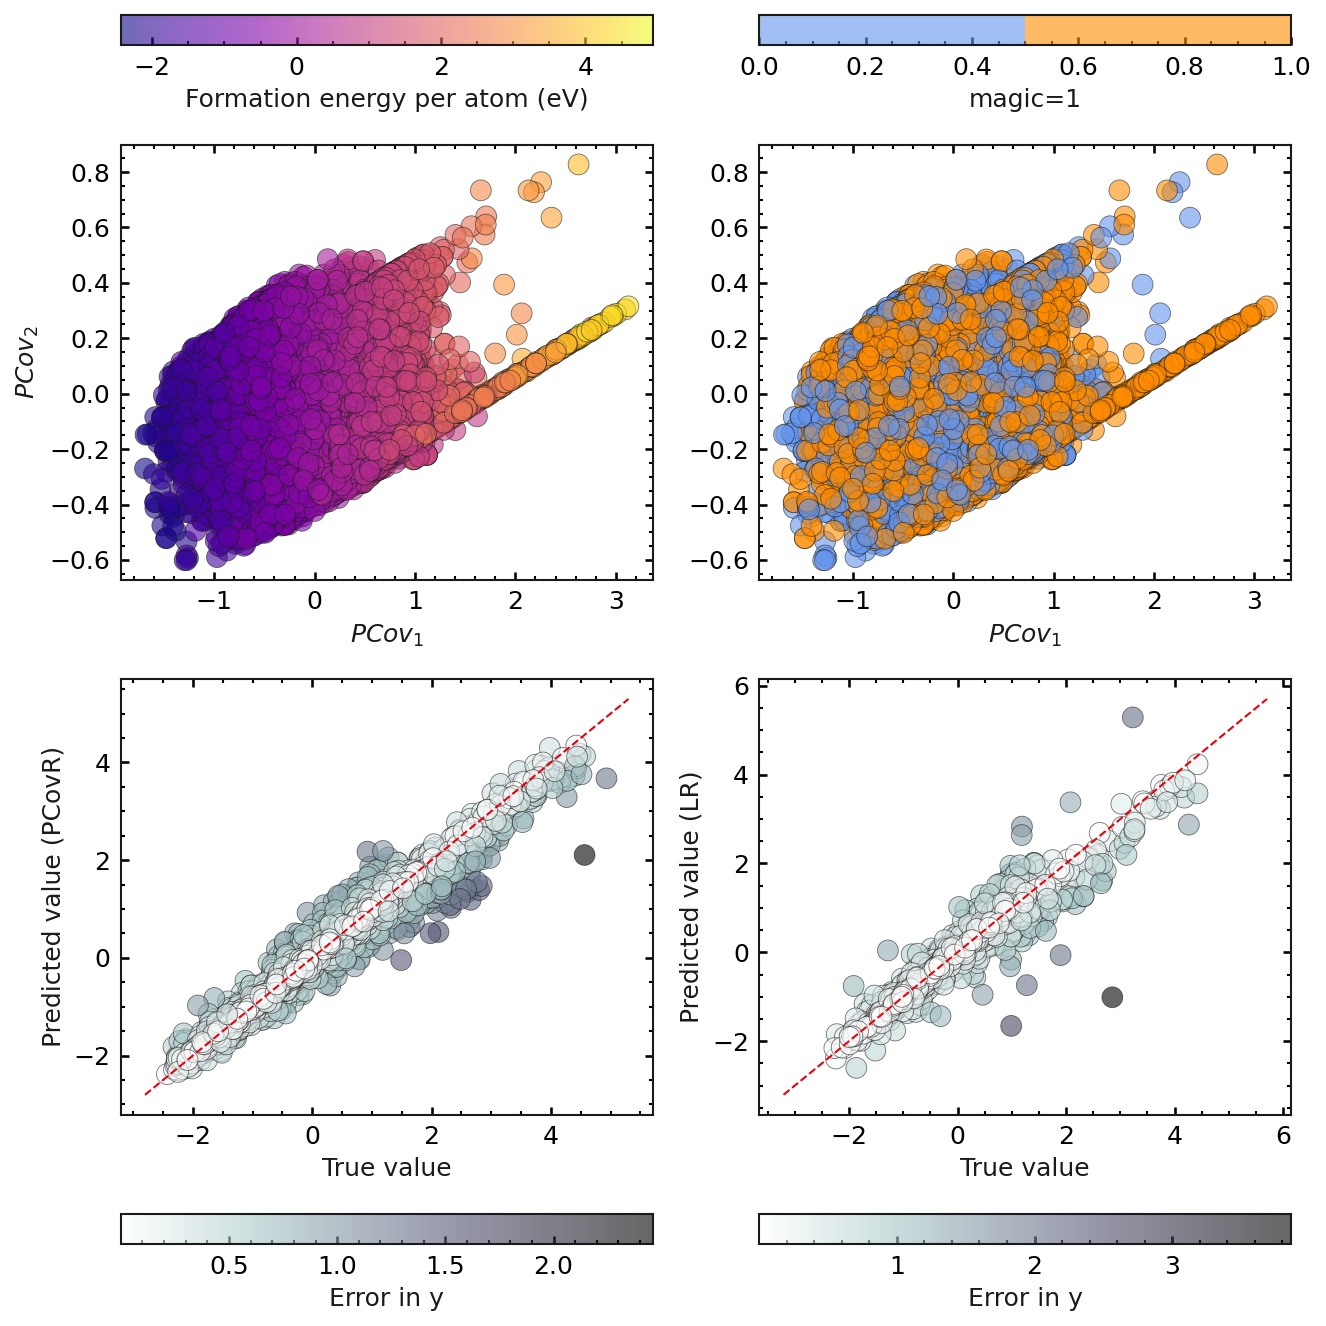

R^2 with PCovR=  0.992935245585
R^2 of testing is with RidgeCV 0.591787421246
RMSE on predicted quantity =  0.269488746705
error in units (eV) of predicted quantity before scaling =  [ 2.3791041]
error in units (eV) of predicted quantity after scaling=  [ 5.56327268]


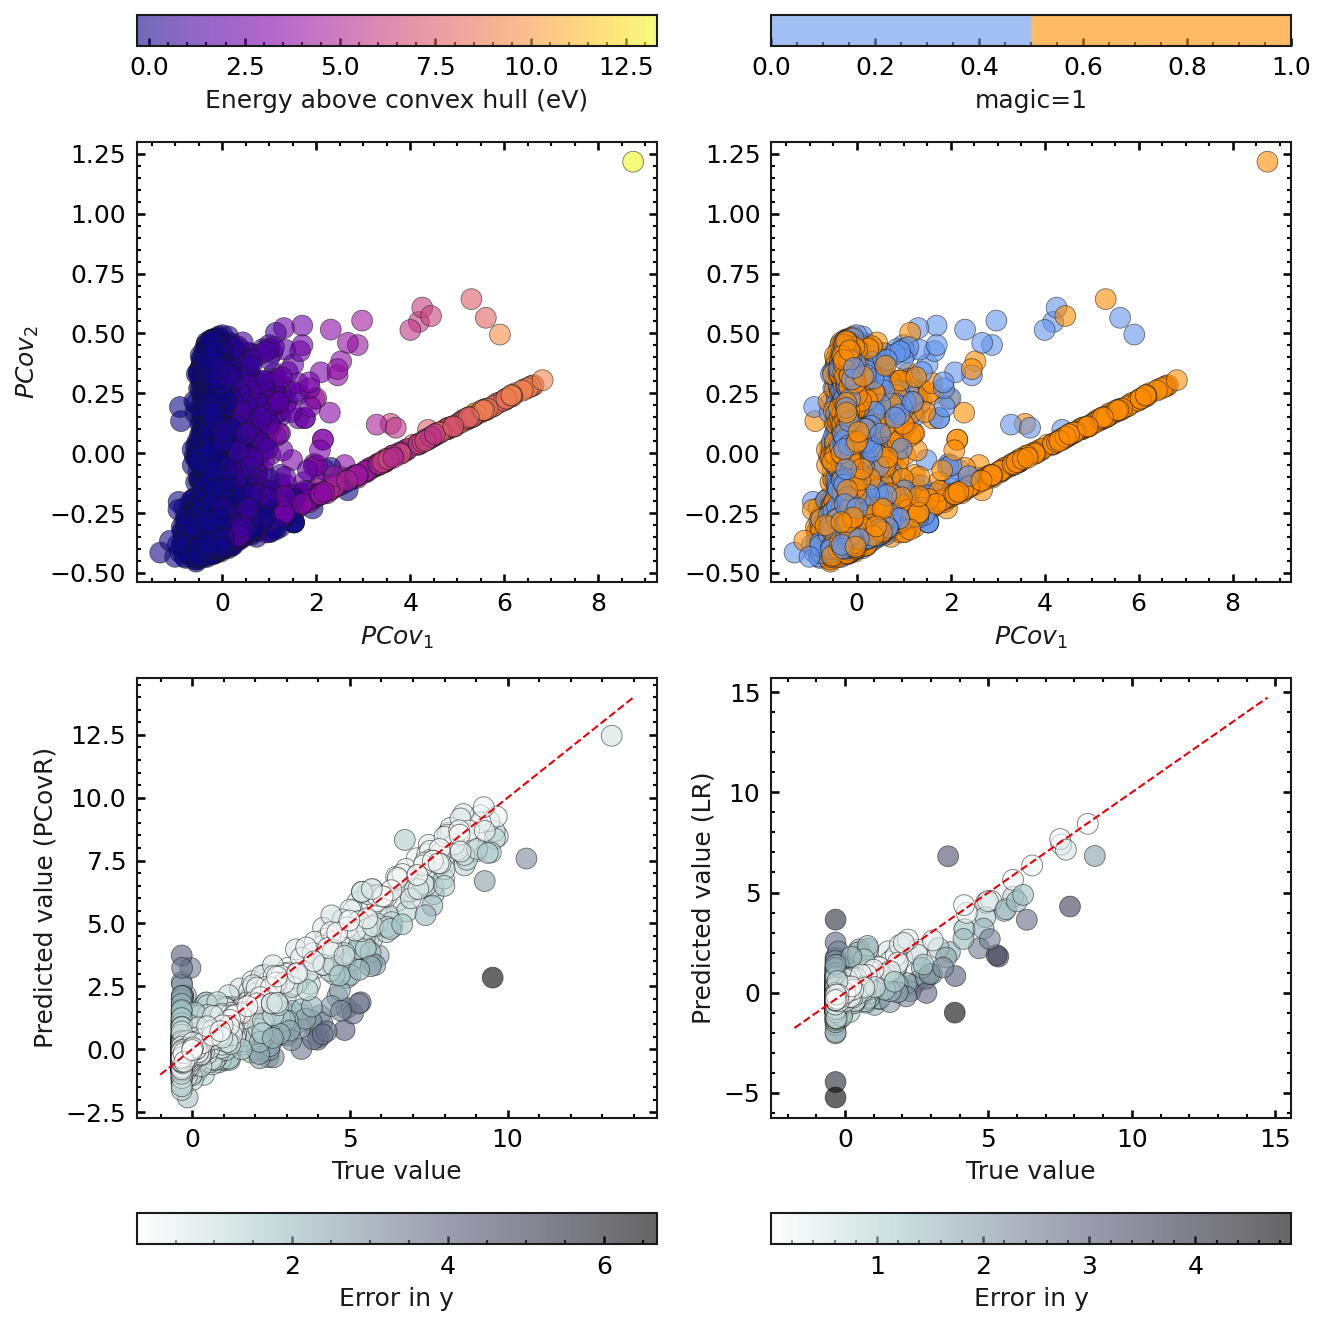

R^2 with PCovR=  1.05847699815
R^2 of testing is with RidgeCV 0.625982276052
RMSE on predicted quantity =  0.375665578239
error in units (eV) of predicted quantity before scaling =  [ 6.6450607]
error in units (eV) of predicted quantity after scaling=  [ 4.23598019]


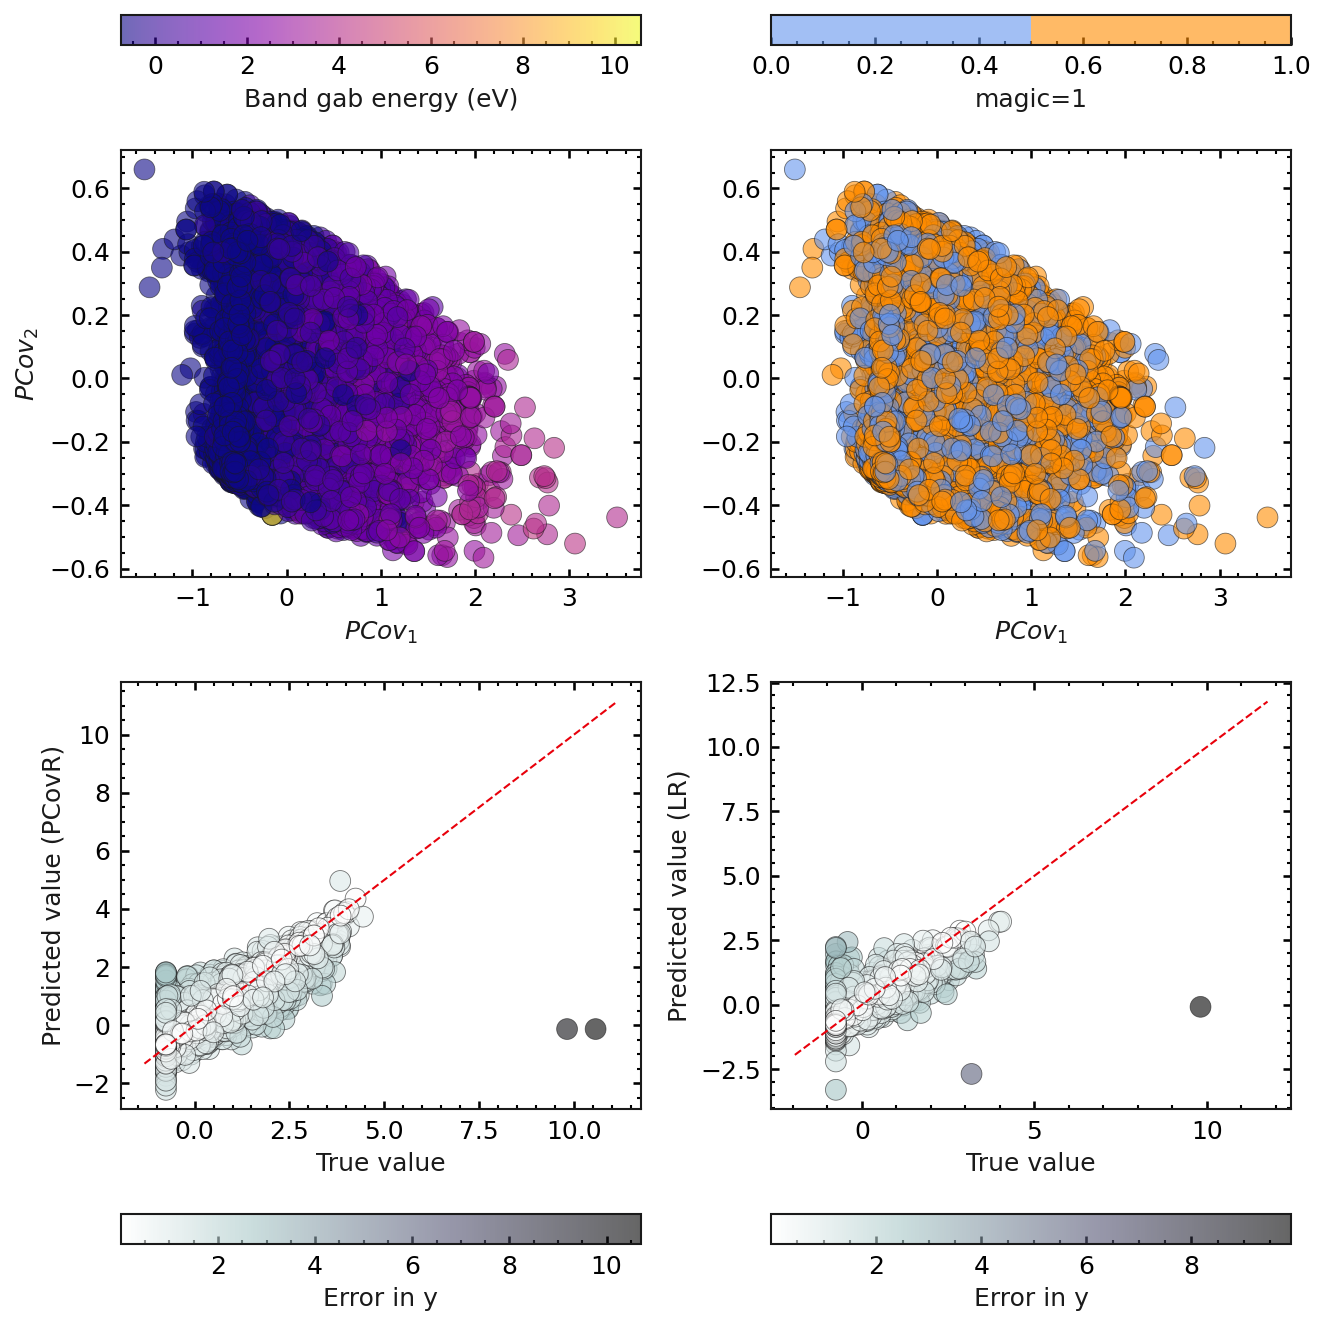

R^2 with PCovR=  1.10569863513
R^2 of testing is with RidgeCV 0.550962431954
RMSE on predicted quantity =  0.381651113321
error in units (eV) of predicted quantity before scaling =  [ 106.79759948]
error in units (eV) of predicted quantity after scaling=  [ 8.23449245]


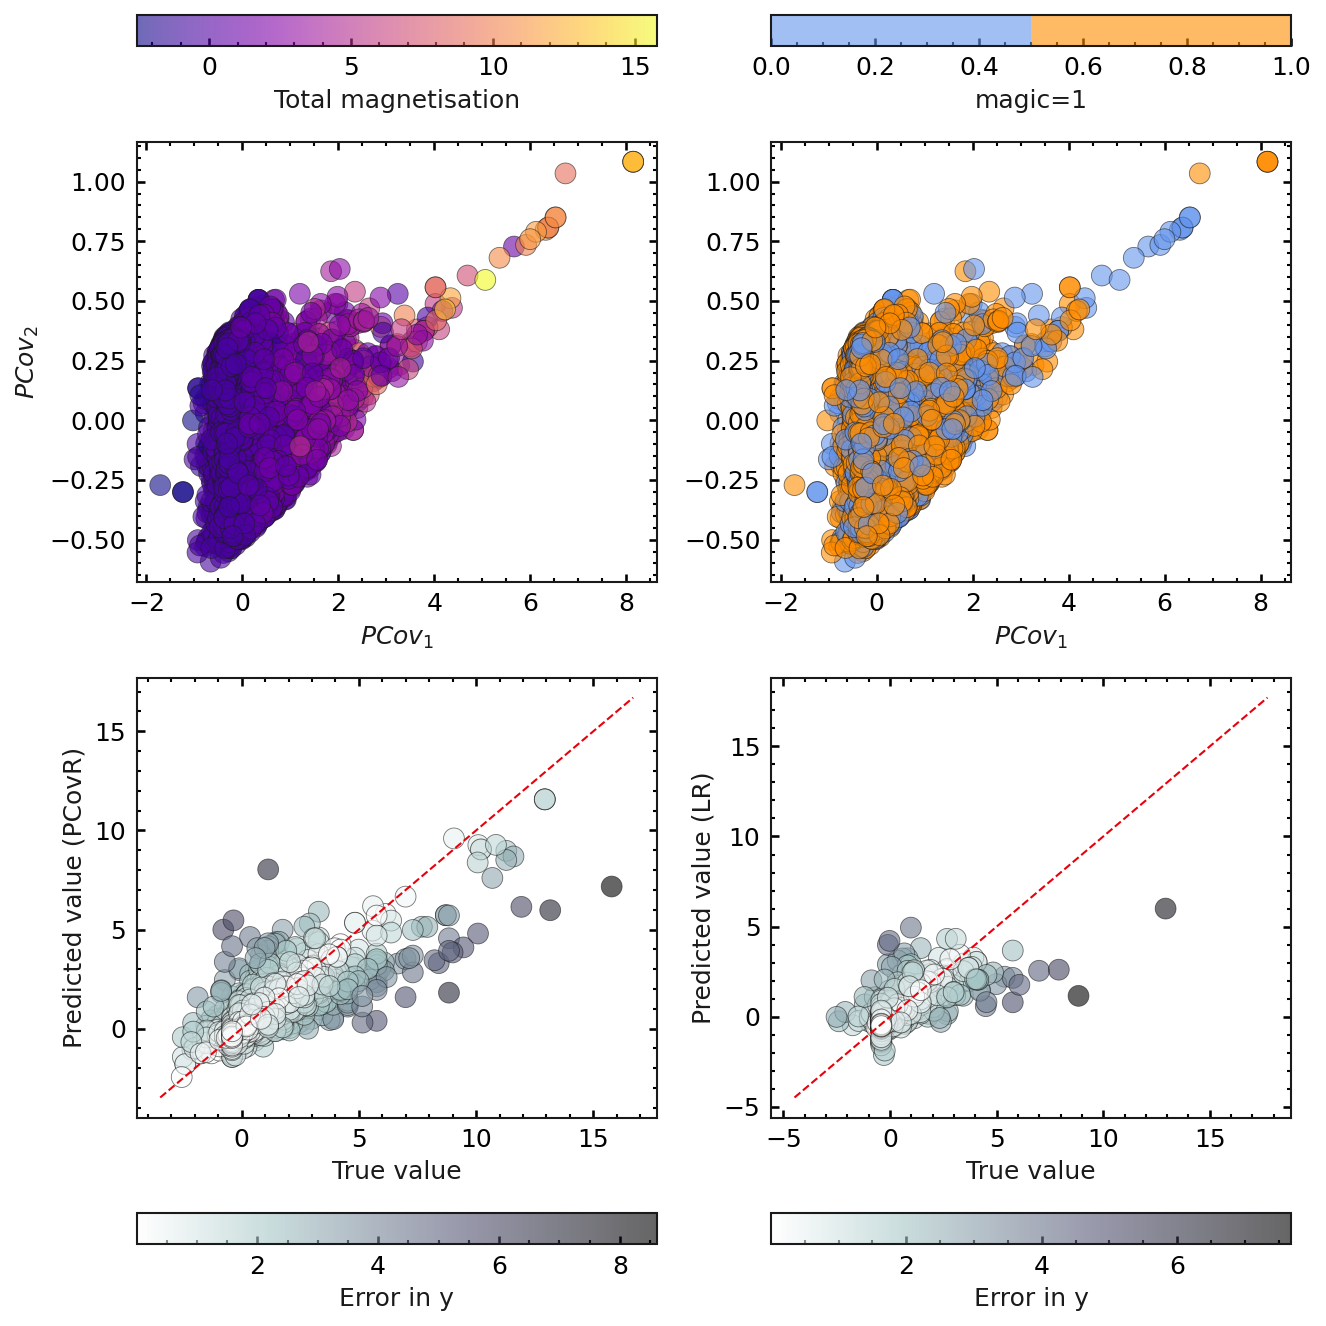

IndexError: list index out of range

In [27]:
titles=['Formation energy per atom (eV)', 'Energy above convex hull (eV)', 'Band gab energy (eV)', 'Total magnetisation']
       # 'Elastic anisotropy ratio', 'Bulk modulus (GPa)', 'Shear modulus (GPa)']

for i in range(len(titles)+1):
    
    X=np.copy(X_raw_tot)
    y_raw=y_merged[i]
    
    i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
    np.arange(X.shape[0]), X, y_raw, train_size=0.8
    )

    x_scaler = StandardFlexibleScaler(column_wise=False).fit(X)
    y_scaler = StandardFlexibleScaler(column_wise=True).fit(y_raw)

    # Center total dataset
    X = x_scaler.transform(X)
    Y = y_scaler.transform(y_raw)

    # Center training data
    X_train = x_scaler.transform(X_train)
    y_train = y_scaler.transform(y_train)

    # Center training data
    X_test = x_scaler.transform(X_test)
    y_test = y_scaler.transform(y_test)
    
    pcovr.fit(X,Y)
    
    T = pcovr.transform(X)
    yp = pcovr.predict(X)
    
    ridgecv.fit(X_train, y_train)
    yp_test=ridgecv.predict(X_test)

    fig, ((caxT, caxM),(axT, axM),  (axy, axy_reg), (caxy, caxy_reg)) = plt.subplots(
        4, 2, figsize=(9,9), gridspec_kw=dict(height_ratios=(0.07, 1, 1, 0.07)))

    scatT = axT.scatter(T[:, 0], T[:, 1], alpha=0.6, c=Y, cmap='plasma', edgecolor="k")
    axT.set_xlabel(r"$PCov_1$")
    axT.set_ylabel(r"$PCov_2$")
#     axT.set_title("Latent Projection")
    fig.colorbar(scatT, cax=caxT, label=titles[i], orientation="horizontal")

    scatM = axM.scatter(T[:, 0], T[:, 1], alpha=0.6, c=y_atom, cmap = colors.ListedColormap(['cornflowerblue', 'darkorange']), edgecolor="k")
    axM.set_xlabel(r"$PCov_1$")
#     axM.set_ylabel(r"$PCov_2$")
#     axM.set_title("Latent Projection")
    fig.colorbar(scatM, cax=caxM, label="magic=1", orientation="horizontal")

    scaty = axy.scatter(Y, yp, alpha=0.6, c=np.abs(Y - yp), cmap='bone_r', edgecolor="k")
    axy.plot(axy.get_xlim(), axy.get_xlim(), 'r--')
    axy.set_xlabel(r"True value")
    axy.set_ylabel(r"Predicted value (PCovR)")
#     axy.set_title("Regression with PCovR")
    fig.colorbar(scaty, cax=caxy,label='Error in y', orientation="horizontal")
    
    scaty_reg=axy_reg.scatter(y_test, yp_test, c=np.abs(y_test - yp_test), cmap="bone_r", ec="k", alpha=0.6,)    
    axy_reg.plot(axy.get_xlim(), axy.get_xlim(), 'r--')
    axy_reg.set_xlabel(r"True value")
    axy_reg.set_ylabel(r"Predicted value (LR)")
#     axy.set_title("Linear Regression")
    fig.colorbar(scaty_reg, cax=caxy_reg,label='Error in y', orientation="horizontal")
    
#     fig.suptitle(str(titles[i]))
    fig.tight_layout()

    print('R^2 with PCovR= ', pcovr.score(X,Y))
    print('R^2 of testing is with RidgeCV', ridgecv.score(X_test,y_test))
    print("RMSE on predicted quantity = ", mean_squared_error(y_test, yp_test))
    print("error in units (eV) of predicted quantity before scaling = ", (max(y_raw)-min(y_raw))*(1-ridgecv.score(X_test,y_test)))
    print("error in units (eV) of predicted quantity after scaling= ", (max(Y)-min(Y))*(1-ridgecv.score(X_test,y_test)))

    plt.show()
    plt.close()